# Clustering with Derived Variables

First let's load the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Filter_Unmerged.csv').drop(columns = ['Unnamed: 0'])
df.head()

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,Tor%,FTA,...,3PM,FGM,FGA,PTS,MINS,AST,REB,BLK,TOV,STL
0,Alex Abrines,Okc,G,25.69,31,19.0,39.5,12.2,7.9,13,...,41.021,56.021,157,164.3,589.0,18.6,46.5,5.89,13.95,17.05
1,Jaylen Adams,Atl,G,22.93,34,12.6,26.2,13.5,19.7,9,...,25.012,38.008,110,108.8,428.4,64.6,61.2,5.10,27.88,12.92
2,Steven Adams,Okc,C,25.73,80,33.4,69.5,16.4,12.8,292,...,0.000,480.972,809,1112.0,2672.0,128.0,760.0,76.80,138.40,119.20
3,Bam Adebayo,Mia,C,21.73,82,23.3,48.6,15.8,17.1,226,...,3.000,279.948,486,729.8,1910.6,180.4,598.6,64.78,121.36,72.16
4,Deng Adel,Cle,F,22.19,19,10.2,21.3,9.9,13.7,4,...,6.003,11.008,36,32.3,193.8,5.7,19.0,3.99,6.08,0.95


### Feature Engineering

Let's create some new columns that will be more usful in calssifying players acccording to their styles.

In [2]:
for col in ['PTS', 'AST', 'REB', 'BLK', 'TOV', 'STL']:
    df[col + 'P36'] = df[col] * 36 / df['MINS']
df['O/DRTG'] = df['ORTG'] / df['DRTG']
df['3/2FGA'] = df['3PA'] / df['2PA']
df['%FTA'] = df['FTA'] / (df['FGA'] + df['FTA'])
print(list(df.columns))

['FULL NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'Tor%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG', '2PM', '3PM', 'FGM', 'FGA', 'PTS', 'MINS', 'AST', 'REB', 'BLK', 'TOV', 'STL', 'PTSP36', 'ASTP36', 'REBP36', 'BLKP36', 'TOVP36', 'STLP36', 'O/DRTG', '3/2FGA', '%FTA']


### Feature Selection

Here, we create a list of the columns we want to use as parameters to the clustering alrogithm, called `cols_to_keep`. We ensure that none of these columns contain missing values.

In [15]:
cols_to_keep = ['USG%', 'Tor%', 'TS%', 'PTSP36', 'ASTP36', 'REBP36', 'BLKP36', 'TOVP36', 'STLP36', 'O/DRTG', '3/2FGA', '%FTA']
cluster_df = df[cols_to_keep]
cluster_df.isnull().sum().sum()

0

Let's take a look at the correlation of these stats.

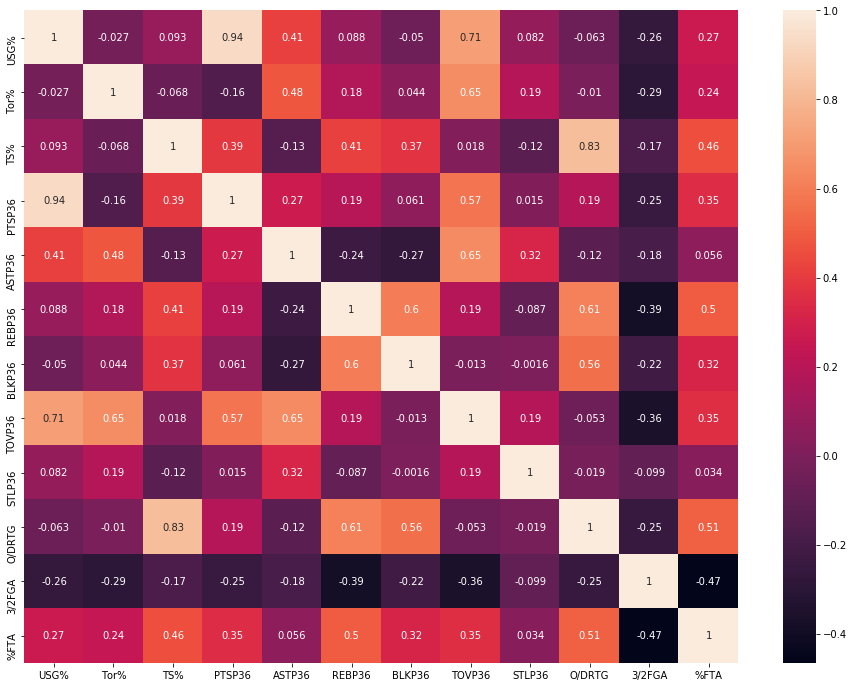

In [16]:
import seaborn as sn
plt.figure(figsize=(16,12))
sn.heatmap(cluster_df.corr(), annot=True)
plt.show()

We can also take a look at the distributions of each stat.

In [17]:
df[cols_to_keep].describe()

,USG%,Tor%,TS%,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,O/DRTG,3/2FGA,%FTA
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,18.785852,12.154455,0.548287,15.337947,3.385311,6.733290,0.764913,1.925235,1.112010,1.055743,0.790635,0.193341
std,5.180464,3.528923,0.056510,4.707338,2.000050,3.116203,0.701144,0.759908,0.421685,0.117123,0.829109,0.073030
min,7.771832,3.700000,0.309569,3.380171,0.564706,1.963636,0.000000,0.400000,0.000000,0.680954,0.000000,0.000000
25%,15.100000,9.700000,0.518000,11.999691,1.862069,4.355428,0.320857,1.350545,0.801799,0.977408,0.337386,0.140104
50%,17.825402,11.700000,0.552014,14.764671,2.730166,5.926346,0.554621,1.797589,1.064018,1.046858,0.614023,0.186958
75%,22.100000,14.200000,0.583000,18.069771,4.581818,8.641840,0.984609,2.334836,1.342849,1.129008,1.076719,0.239867
max,40.500000,26.800000,0.720000,35.315217,10.700000,17.613734,5.337931,4.852174,2.537705,1.444331,10.615385,0.467742


And, finally, let us plot histograms of the columns.

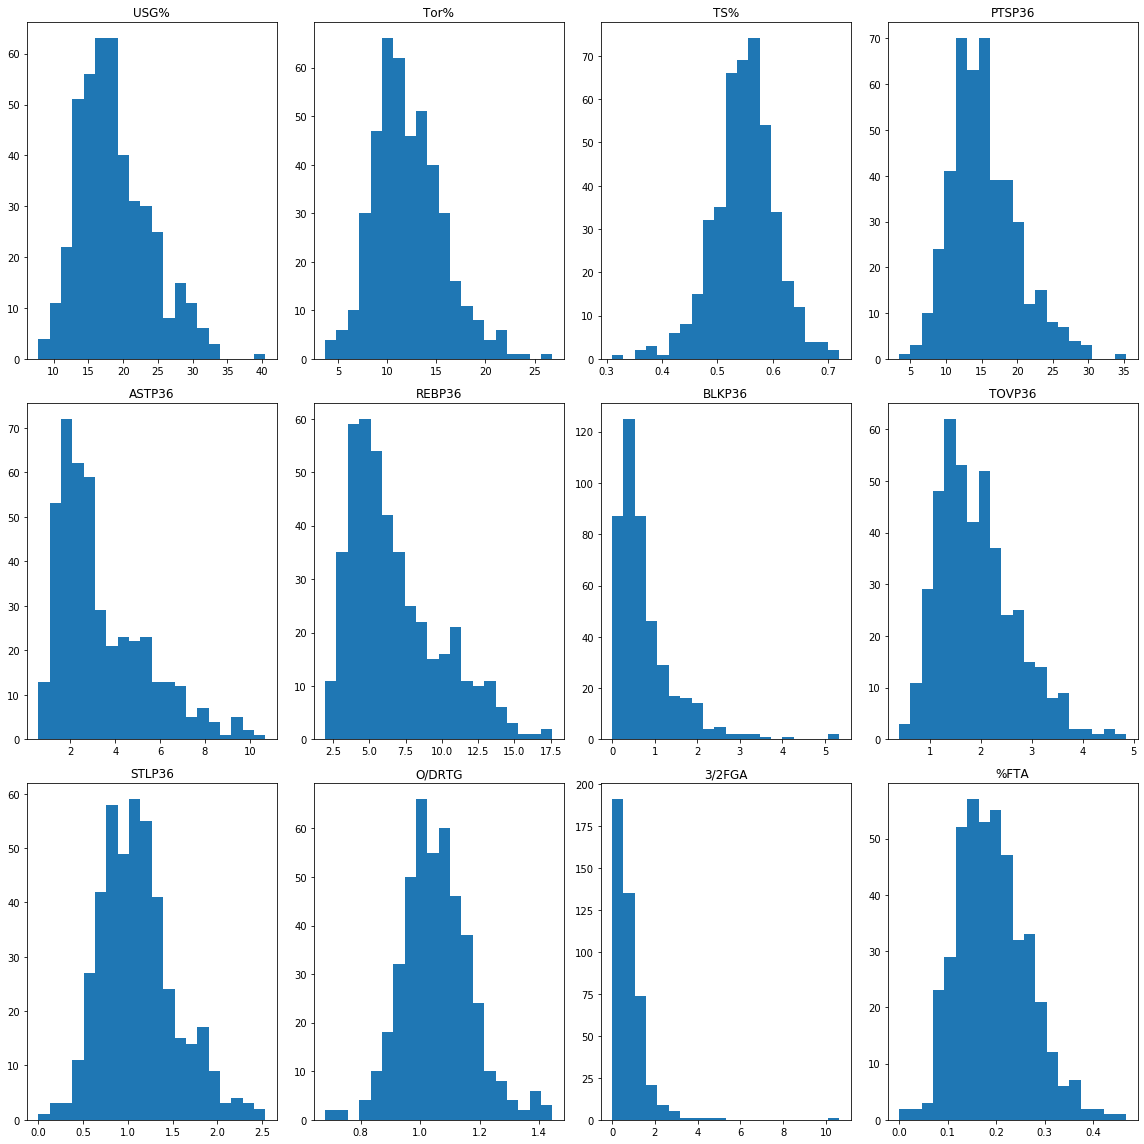

In [19]:
plt.subplots(3, 4, figsize=(16, 16))
for i in range(len(cols_to_keep)):
    plt.subplot(3, 4, i+1)
    plt.hist(cluster_df[cols_to_keep[i]], bins=20)
    plt.title(cols_to_keep[i])
    plt.tight_layout()
plt.show()

### Standardization

From these distributions, it seems the selected stats are approximately normally distributed. In order to avoid scaling issues, let us standardize the columns with z-scores.

In [20]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
cluster_df = pd.DataFrame(scaler.fit_transform(cluster_df), columns=cols_to_keep)
cluster_df.head()

,USG%,Tor%,TS%,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,O/DRTG,3/2FGA,%FTA
0,-1.272733,-1.206968,-0.731435,-1.126299,-1.125486,-1.250116,-0.578160,-1.413097,-0.165965,-0.542290,4.157012,-1.602126
1,-1.021505,2.140634,-1.316064,-1.317547,1.022768,-0.510956,-0.480250,0.550195,-0.062431,-1.156499,1.527374,-1.613645
2,-0.461072,0.183138,0.756711,-0.075694,-0.831305,1.126442,0.385263,-0.079790,1.172771,0.955085,-0.951689,0.985258
3,-0.577024,1.403027,1.323624,-0.337490,0.006923,1.460384,0.650660,0.476204,0.587946,1.528552,-0.916227,1.700873
4,-1.717214,0.438463,-2.201865,-1.985958,-1.164539,-1.029306,-0.033892,-1.048454,-2.221101,-2.722382,1.181641,-1.279572


### Clustering

Let us try models with the number of clusters ranging from 5 to 15.

In [21]:
from sklearn.cluster import KMeans
inertias = []
num_data = cluster_df._get_numeric_data().dropna(axis = 1)
for i in range(5, 15):
    test_model = KMeans(n_clusters = i, random_state = 1) #test using just 5 clusters
    test_model.fit(num_data)
    inertias.append(test_model.inertia_)
print(inertias)

[2895.3969807073363, 2754.2818368928247, 2617.9464191423394, 2488.5400353557575, 2370.0584719626163, 2276.2210189638854, 2204.7307906249507, 2125.2894976071107, 2069.094347469567, 1998.6398596015301]


We create a plot of the "intertias" per number of clusteras and use the elbow method to determine the best number of clusters.

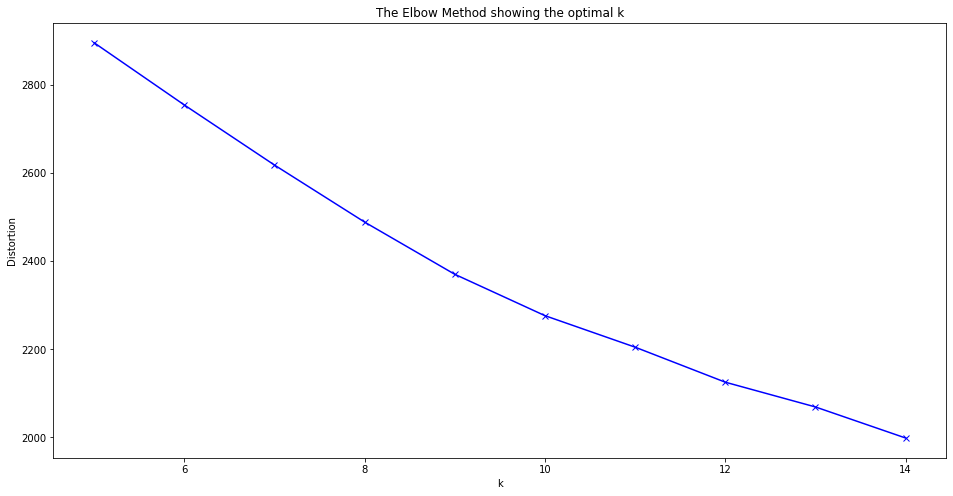

In [22]:
plt.figure(figsize=(16,8))
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Analysis

We can now look at the relative size of each cluster.

In [23]:
test_model = KMeans(n_clusters = 12, random_state = 1)
test_model.fit(num_data)
df['Cluster'] = test_model.labels_
df['Cluster'].value_counts()

1     70
0     70
8     44
7     39
4     39
10    38
6     34
5     34
3     30
11    28
2     10
9      4
Name: Cluster, dtype: int64

We can also look at the distribution by position within each cluster.

ValueError: 'label' must be of length 'x'

<Figure size 1152x576 with 0 Axes>

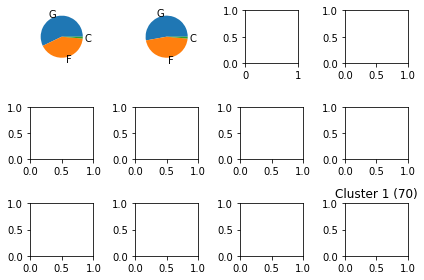

In [44]:
"""
ax[0].pie(sizes, labels=labels)
ax[1].pie(sizes[1:], labels=labels[1:])
colours = {'Frogs': 'C0',
           'Hogs': 'C1',
           'Dogs': 'C2',
           'Logs': 'C3'}
fig, ax = plt.subplots(1, 2)

ax[0].pie(sizes,
          labels=labels,
          colors=[colours[key] for key in labels])

ax[1].pie(sizes[1:],
          labels=labels[1:],
          colors=[colours[key] for key in labels[1:]])

colours = {'G': 'C0',  'F': 'C1', 'C': 'C2'}
plt.figure(figsize=(16,8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.title("Cluster " + str(i) + " (" + str(len(df[df['Cluster'] == i])) + ")")
    plt.tight_layout()
    df[df['Cluster'] == i]['POS'].value_counts().plot.pie(labels = colors.keys(), colors=[colours[key] for key in colours])  
plt.show()"""

plt.figure(figsize=(16,8))
colours = {'G': 'C0',  'F': 'C1', 'C': 'C2'}
fig, ax = plt.subplots(3, 4)
for i in range(12):
    ax[int(i/4)][i%4].pie(df[df['Cluster'] == i]['POS'].value_counts(), labels=list(colours.keys()), colors=[colours[key] for key in colours])
    plt.title("Cluster " + str(i) + " (" + str(len(df[df['Cluster'] == i])) + ")")
    plt.tight_layout()
plt.show()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C34CF80A48>,
      dtype=object)

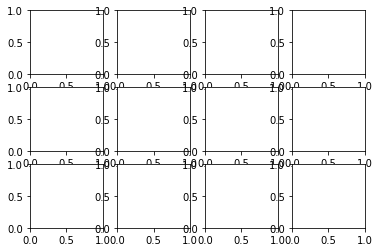

In [40]:
fig, ax = plt.subplots(3, 4)
ax[0]

Finally, we can look at the distribution of specific statistics within each cluster and contrast.

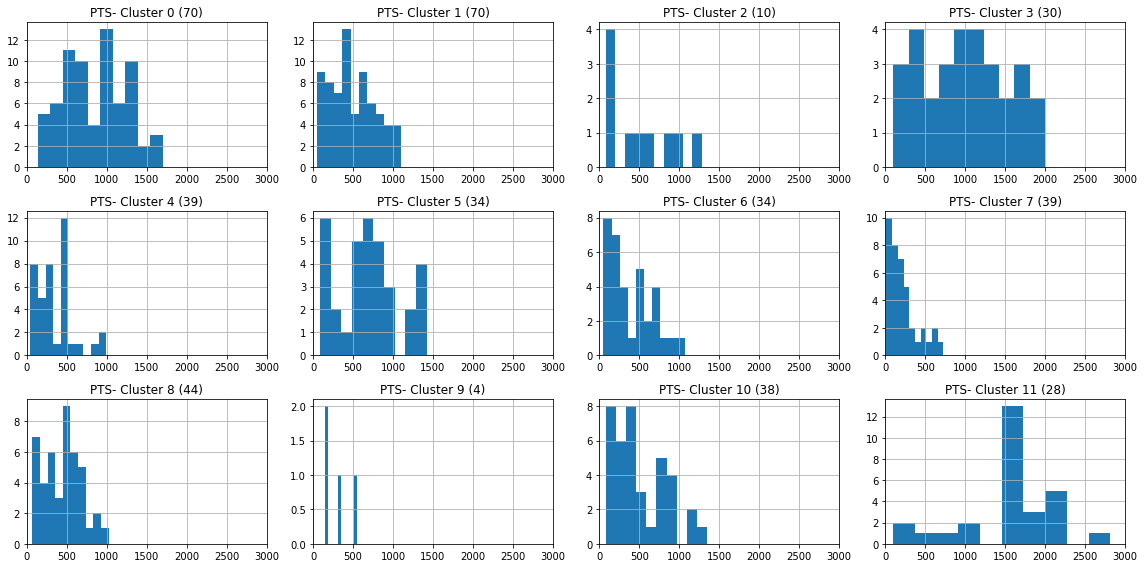

In [29]:
stat = 'PTS'
plt.figure(figsize=(16,8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.title(stat + "- Cluster " + str(i) + " (" + str(len(df[df['Cluster'] == i])) + ")")
    plt.xlim(0, 3000)
    plt.tight_layout()
    df[df['Cluster'] == i][stat].hist()
plt.show()